In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import nltk
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score, accuracy_score, f1_score, precision_score, dcg_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix, mean_squared_error

from gensim.models import Word2Vec, doc2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.layers import Input, Dense, Concatenate, concatenate, Dropout, Reshape, dot, Dot
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from imblearn.under_sampling import NearMiss, RandomUnderSampler

## 1. Load Dataset
* The original behavior dataset was: "behaviors.tsv"
* "small_behavior.csv" was made with these commands:
    * behavior = behavior_raw.sample(n=5000, random_state=12345)
    * behavior.to_csv("small_behavior.csv")

In [ ]:
behavior_raw = pd.read_csv("small_behavior.csv")
news_raw = pd.read_csv("MINDlarge_train/news.tsv", sep="\t", header=None)
news_raw.columns = ["news_id", "category", "sub_category", "title", "abstract", "url", "title_ent", "abs_ent"]

## 2. Preprocessing

In [26]:
behavior2 = behavior_raw.drop(["time", "imp_id"], axis=1).copy()
news2 = news_raw.drop(["sub_category", "url", "title_ent", "abs_ent"], axis=1).copy()

In [27]:
news2["abstract"] = news2["abstract"].fillna(" ")
news2["text"] = news2["title"] + " " + news2["abstract"]
news2.drop(["title", "abstract"], axis=1, inplace=True)

In [28]:
behavior3 = behavior2.copy()
behavior3['impressions'] = behavior3['impressions'].str.split(' ')
behavior3 = behavior3.explode('impressions')
behavior3['clicked'] = behavior3['impressions'].str[-1]
behavior3['rating'] = behavior3['clicked'].astype(int)
behavior3['news_id'] = behavior3['impressions'].str[:-2]
behavior3.drop(["impressions", "clicked"], axis=1, inplace=True)
behavior3.reset_index(drop=True, inplace=True)

In [29]:
behavior = behavior3.dropna(axis=0)
behavior = behavior.reset_index(drop=True)
news = news2.dropna(axis=0)
news = news.reset_index(drop=True)

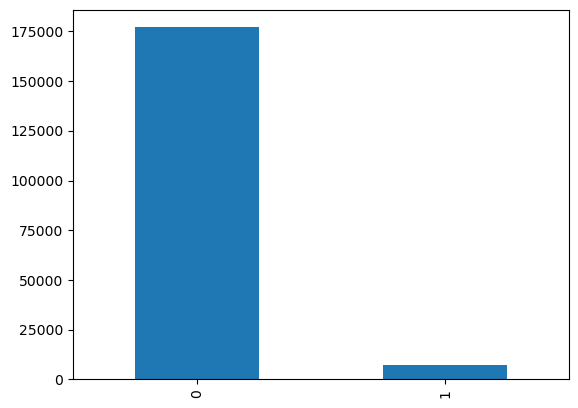

In [30]:
behavior['rating'].value_counts().plot(kind='bar')
plt.show()

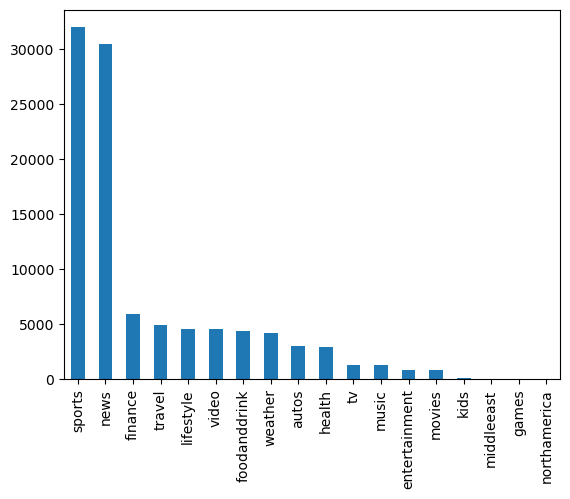

In [31]:
news['category'].value_counts().plot(kind='bar')
plt.show()

In [32]:
user_history = behavior.copy()
def news_text(n_id):
    return news[news["news_id"] == n_id]["text"].values[0].strip()

In [34]:
user_history["text"] = user_history["news_id"].apply(news_text)

In [58]:
dup = user_history.duplicated(['user_id', 'news_id'], keep='first')
df_dup = pd.concat([user_history, dup], axis=1)
df_dup.rename(columns = {0 : 'Dup'}, inplace = True)
dup_index = df_dup[df_dup["Dup"]==True].index
user_hist = user_history.drop(dup_index, axis=0)
user_hist = user_hist.reset_index(drop=True)

In [36]:
user_hist.head()

,user_id,history,rating,news_id,text
0,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N23294,Two sisters raise thousands to buy 108 Thanksg...
1,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N84689,Jennifer Lopez Just Got a Teeny Chop to Her Bl...
2,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N76936,Read George Kent Full Opening Statement at the...
3,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N68164,​'My Annoying Cough Turned Out To Be Lung Canc...
4,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N109852,Hero Police Officer Saves Driver From Fiery Crash


### The final dataset after preprocessing was saved as "user_history_5000behavior.csv"

In [5]:
user_hist = pd.read_csv("user_history_small_behavior.csv")
user_hist.head()

,user_id,history,rating,news_id,text
0,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N23294,Two sisters raise thousands to buy 108 Thanksg...
1,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N84689,Jennifer Lopez Just Got a Teeny Chop to Her Bl...
2,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N76936,Read George Kent Full Opening Statement at the...
3,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N68164,​'My Annoying Cough Turned Out To Be Lung Canc...
4,U380940,N55571 N155 N37069 N9594 N65119 N73122 N46069 ...,0,N109852,Hero Police Officer Saves Driver From Fiery Crash


## 3. Doc2Vec Embedding

In [39]:
doc_tag = []

for index, row in tqdm(user_hist.iterrows(), total=len(user_hist)):
    text = row['text']
    tag = row['user_id'], row['news_id']
    doc_tag.append(TaggedDocument(tags=[tag], words=nltk.tokenize.word_tokenize(text)))

print('documents:', len(doc_tag))

100%|████████████████████████████████████████████████████████████████████████| 184343/184343 [00:46<00:00, 3987.76it/s]

documents: 184343


In [40]:
model_doc2vec = doc2vec.Doc2Vec(vector_size=128, alpha=0.025, min_alpha=0.025, workers=8, window=8)
model_doc2vec.build_vocab(doc_tag)

In [41]:
X = model_doc2vec.docvecs.vectors
y = user_hist["rating"]

C:\Users\squar\AppData\Local\Temp\ipykernel_85864\1590147559.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  X = model_doc2vec.docvecs.vectors


In [48]:
NM_model = NearMiss(version=2)
X_samp, y_samp = NM_model.fit_resample(X,y)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, test_size = 0.3, random_state=12345)
y_train =  np.array(y_train)
y_test =  np.array(y_test)

In [49]:
def top_5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

def top_10(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=10)

In [50]:
def recommend_model_k_5():
    user_input = Input(shape=(128, ))
    
    dense = Dense(128, activation = 'relu')(user_input)
    dense = Dropout(0.1)(dense)
    dense = Dense(64, activation = 'relu')(dense)
    dense = Dropout(0.1)(dense)
    dense = Dense(32, activation = 'relu')(dense)
    dense = Dropout(0.1)(dense)
    dense = Dense(16, activation = 'relu')(dense)
    dense = Dense(1, activation = 'sigmoid')(dense)

    model = Model(inputs=user_input, outputs=dense)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', top_5])
    return model

def recommend_model_k_10():
    user_input = Input(shape=(128, ))
    
    dense = Dense(128, activation = 'relu')(user_input)
    dense = Dropout(0.1)(dense)
    dense = Dense(64, activation = 'relu')(dense)
    dense = Dropout(0.1)(dense)
    dense = Dense(32, activation = 'relu')(dense)
    dense = Dropout(0.1)(dense)
    dense = Dense(16, activation = 'relu')(dense)
    dense = Dense(1, activation = 'sigmoid')(dense)

    model = Model(inputs=user_input, outputs=dense)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', top_10])
    return model

model_5 = recommend_model_k_5()
model_10 = recommend_model_k_10()

In [255]:
modelpath = 'save/recommender.model'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [157]:
model_5.fit(X_train, y_train, validation_split = 0.2, epochs=30, batch_size=64, callbacks=[early_stop, checkpointer])

Epoch 1/30
105/130 [=======================>......] - ETA: 0s - loss: 0.6932 - top_5: 1.0000
Epoch 1: val_loss improved from inf to 0.69321, saving model to save\recommender.model
INFO:tensorflow:Assets written to: save\recommender.model\assets
130/130 [==============================] - 1s 8ms/step - loss: 0.6932 - top_5: 1.0000 - val_loss: 0.6932 - val_top_5: 1.0000
Epoch 2/30
107/130 [=======================>......] - ETA: 0s - loss: 0.6931 - top_5: 1.0000
Epoch 2: val_loss did not improve from 0.69321
130/130 [==============================] - 0s 2ms/step - loss: 0.6932 - top_5: 1.0000 - val_loss: 0.6932 - val_top_5: 1.0000
Epoch 3/30
120/130 [==========================>...] - ETA: 0s - loss: 0.6929 - top_5: 1.0000
Epoch 3: val_loss did not improve from 0.69321
130/130 [==============================] - 0s 2ms/step - loss: 0.6930 - top_5: 1.0000 - val_loss: 0.6934 - val_top_5: 1.0000
Epoch 4/30
113/130 [=========================>....] - ETA: 0s - loss: 0.6928 - top_5: 1.0000
Epoch 4

In [160]:
model_10.fit(X_train, y_train, validation_split = 0.2, epochs=30, batch_size=64, callbacks=[early_stop, checkpointer])

Epoch 1/30
114/130 [=========================>....] - ETA: 0s - loss: 0.2712 - top_10: 1.0000
Epoch 1: val_loss improved from inf to 0.78626, saving model to save\recommender.model
INFO:tensorflow:Assets written to: save\recommender.model\assets
130/130 [==============================] - 1s 7ms/step - loss: 0.2734 - top_10: 1.0000 - val_loss: 0.7863 - val_top_10: 1.0000
Epoch 2/30
107/130 [=======================>......] - ETA: 0s - loss: 0.2352 - top_10: 1.0000
Epoch 2: val_loss did not improve from 0.78626
130/130 [==============================] - 0s 2ms/step - loss: 0.2407 - top_10: 1.0000 - val_loss: 0.8163 - val_top_10: 1.0000
Epoch 3/30
107/130 [=======================>......] - ETA: 0s - loss: 0.2293 - top_10: 1.0000
Epoch 3: val_loss did not improve from 0.78626
130/130 [==============================] - 0s 2ms/step - loss: 0.2269 - top_10: 1.0000 - val_loss: 0.8782 - val_top_10: 1.0000
Epoch 4/30
107/130 [=======================>......] - ETA: 0s - loss: 0.1831 - top_10: 1.00

In [259]:
pred_5 = model_5.predict(X_test)
pred_5_label = [1 if i > 0.5 else 0 for i in pred_5]
pred_10 = model_10.predict(X_test)
pred_10_label = [1 if i > 0.5 else 0 for i in pred_10]

140/140 [==============================] - 0s 718us/step


In [255]:
true_5 = np.asarray( [y_test] )
pred_5 = np.asarray( [pred_5_label] )

print("f1 score:", f1_score(y_test, pred_5_label))
print("precision:", precision_score(y_test, pred_5_label))
print("recall:", recall_score(y_test, pred_5_label))
print("accuracy:", accuracy_score(y_test, pred_5_label))
print("ndcg:", ndcg_score(true_5, pred_5))

f1 score: 0.6384846384846385
precision: 0.6731612274719923
recall: 0.6072056239015817
accuracy: 0.6482355585524837
ndcg: 0.9337555028827785


In [256]:
true_10 = np.asarray( [y_test] )
pred_10 = np.asarray( [pred_10_label] )

print("f1 score:", f1_score(y_test, pred_10_label))
print("precision:", precision_score(y_test, pred_10_label))
print("recall:", recall_score(y_test, pred_10_label))
print("accuracy:", accuracy_score(y_test, pred_10_label))
print("ndcg:", ndcg_score(true_10, pred_10))

f1 score: 0.6429971683729034
precision: 0.6375809935205183
recall: 0.648506151142355
accuracy: 0.6316026073274893
ndcg: 0.9281339284691595


In [8]:
temp_X = X_test[:1000]
temp_y = y_test[:1000]

In [269]:
temp_predictions = model_5.predict(temp_X)
temp_predictions = np.array([p[0] for p in temp_predictions])
temp_recommend = (-temp_predictions).argsort()[:5]
print( "Top 5 news recommendations: " )
user_hist.iloc[temp_recommend][["news_id", "text"]]

32/32 [==============================] - 0s 767us/step
Top 5 news recommendations: 


,news_id,text
294,N8491,'It's the biggest gift I've ever gotten:' Iraq...
620,N32154,Porsche launches into second story of New Jers...
974,N58417,The Most Amazing Photos of a Young Dolly Parto...
713,N4156,Doing This One Simple Thing Can Help You Make ...
471,N4612,Report: Ohio State asks NCAA to reinstate star...
